In [522]:
import yfinance as yf
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
from fred import Fred_Pull

import matplotlib.pyplot as plt

In [523]:
# CSV

gold_price = (
    pd.read_csv('./CSV_Data/gold_usd_data.csv')
    .assign(
        date=lambda df: pd.to_datetime(df['date'],dayfirst=True),
        value=lambda df: pd.to_numeric(df['value'])
    )
    .set_index('date')
    .rename(columns={'value':'gold_nomusd'})
    .resample('ME').mean()
)

In [524]:
# Pull US CPI and US 10YR Yield (Real) from Fred

us_cpi = Fred_Pull('CPIAUCSL','899901ba06f09b9961a73113b1834a15').extract(month_average=True)
us_realyield = Fred_Pull('REAINTRATREARAT10Y','899901ba06f09b9961a73113b1834a15').extract(month_average=True)

In [525]:
df = (
    gold_price.join((us_cpi,us_realyield))
    .assign(
        CPIAUCSL = lambda x: 1/(x.CPIAUCSL/x.CPIAUCSL.iloc[0]),
        gold_realusd = lambda x: x.gold_nomusd*x.CPIAUCSL)
)

In [526]:
df=df[df.REAINTRATREARAT10Y.notna()]

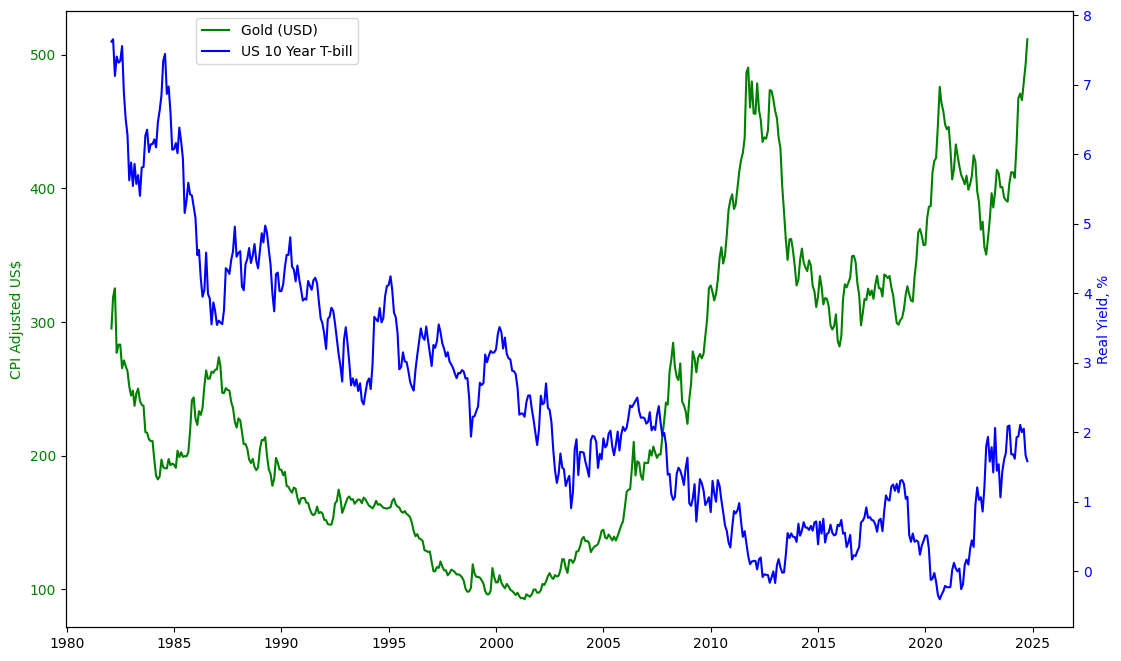

In [527]:
fig, ax1 = plt.subplots()
plt.rcParams["figure.figsize"] = (13,8)

ax1.plot(df.index, df.gold_realusd, 'g-', label='Gold (USD)')
ax1.set_ylabel('CPI Adjusted US$', color='g')
ax1.tick_params(axis='y', labelcolor='g')

ax2 = ax1.twinx()

ax2.plot(df.index, df.REAINTRATREARAT10Y, 'b-', label='US 10 Year T-bill')
ax2.set_ylabel('Real Yield, %', color='b')    
ax2.tick_params(axis='y', labelcolor='b')

fig.legend(loc="upper left", bbox_to_anchor=(0.22,0.88))

# Show the plot

plt.show()

In [528]:
df

,gold_nomusd,CPIAUCSL,REAINTRATREARAT10Y,gold_realusd
date,,,,
1982-01-31,444.29,0.664195,7.623742,295.095159
1982-02-28,481.29,0.662091,7.656648,318.657687
1982-03-31,491.20,0.662091,7.128993,325.219007
1982-04-30,419.70,0.660000,7.408347,277.002000
1982-05-31,432.88,0.653806,7.320041,283.019562
...,...,...,...,...
2024-05-31,2352.14,0.200176,2.103399,470.841018
2024-06-30,2326.33,0.200288,1.999567,465.936294
2024-07-31,2395.31,0.199978,2.048396,479.010050


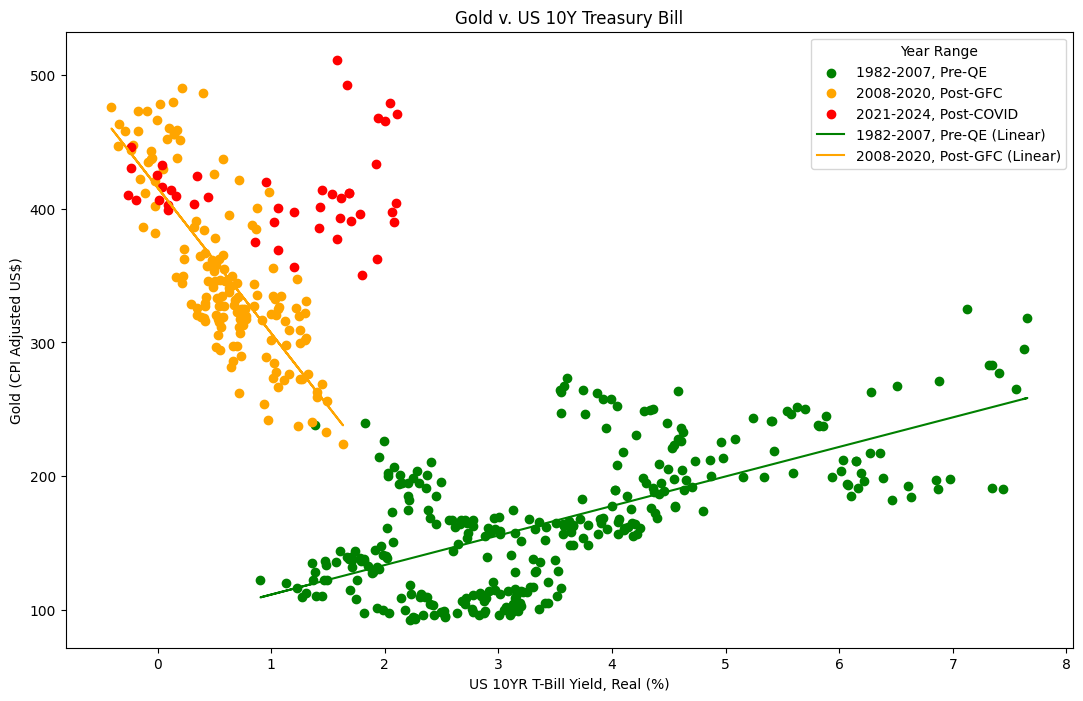

In [529]:
bins = [1982,2008,2021,2025]
labels = ['1982-2007, Pre-QE', '2008-2020, Post-GFC', '2021-2024, Post-COVID']

colors = {
    '1982-2007, Pre-QE': 'green',
    '2008-2020, Post-GFC': 'orange',
    '2021-2024, Post-COVID': 'red',
}

df['YearRange'] = pd.cut(df.index.year,bins=bins,labels=labels,right=False)

fig, ax = plt.subplots()

for label in labels:
    subset = df[df['YearRange'] == label]
    plt.scatter(subset.REAINTRATREARAT10Y, subset.gold_realusd, color=colors[label], label=label)

for label in labels[0:2]:
    subset = df[df['YearRange'] == label]
    subset_eq = np.poly1d(np.polyfit(subset['REAINTRATREARAT10Y'],subset['gold_realusd'],1))
    plt.plot(subset.REAINTRATREARAT10Y,subset_eq(subset.REAINTRATREARAT10Y),color=colors[label], label=label+' (Linear)')

# Add labels, title, and legend
plt.xlabel('US 10YR T-Bill Yield, Real (%)')
plt.ylabel('Gold (CPI Adjusted US$)')
plt.title('Gold v. US 10Y Treasury Bill')
plt.legend(title='Year Range')

# Show the plot
plt.show()

Current Market Data

In [530]:
#   YFinance Pull
gold_price = yf.Ticker("GC=F")
gold_price = (
    gold_price.history(period='max')
    .drop(['Open','High','Low','Volume','Dividends','Stock Splits'],axis=1)
        .assign(
        Close=lambda df: pd.to_numeric(df['Close'])
    )
    .rename(columns={'Close':'gold_nomusd'})
)

gold_price.index = gold_price.index.tz_localize(None).rename('date')

In [531]:
us_cpi = (
    Fred_Pull('CPIAUCSL','899901ba06f09b9961a73113b1834a15').extract()
    .resample('d').mean()
)

us_cpi = (
    us_cpi.reindex(
        pd.date_range(
            us_cpi.index.min(),datetime.today()-timedelta(1)))
            .interpolate(method='linear', limit_direction='forward')
)

us_realyield = Fred_Pull('DFII10','899901ba06f09b9961a73113b1834a15').extract()

In [532]:
us_cpi

,CPIAUCSL
1947-01-01,21.480000
1947-01-02,21.484516
1947-01-03,21.489032
1947-01-04,21.493548
1947-01-05,21.498065
...,...
2024-10-20,314.686000
2024-10-21,314.686000
2024-10-22,314.686000
2024-10-23,314.686000


In [533]:
us_cpi[28365:28375]
#us_cpi

,CPIAUCSL
2024-08-29,314.631323
2024-08-30,314.649548
2024-08-31,314.667774
2024-09-01,314.686000
2024-09-02,314.686000
2024-09-03,314.686000
2024-09-04,314.686000
2024-09-05,314.686000
2024-09-06,314.686000
2024-09-07,314.686000


In [534]:
df = (
    gold_price.join((us_cpi,us_realyield))
    .assign(
        CPIAUCSL = lambda x: 1/(x.CPIAUCSL/x.CPIAUCSL.iloc[0]),
        gold_realusd = lambda x: x.gold_nomusd*x.CPIAUCSL)
    .iloc[-60:-1]
    .interpolate()
)

In [535]:
df

,gold_nomusd,CPIAUCSL,DFII10,gold_realusd
date,,,,
2024-08-01,2435.000000,0.552468,1.79,1345.260625
2024-08-02,2425.699951,0.552436,1.76,1340.044890
2024-08-05,2401.699951,0.552340,1.71,1326.555524
2024-08-06,2389.100098,0.552308,1.78,1319.519575
2024-08-07,2390.500000,0.552276,1.85,1320.216174
2024-08-08,2422.199951,0.552244,1.87,1337.645716
2024-08-09,2432.100098,0.552212,1.84,1343.035120
2024-08-12,2462.399902,0.552116,1.79,1359.530503
2024-08-13,2466.699951,0.552084,1.76,1361.825664


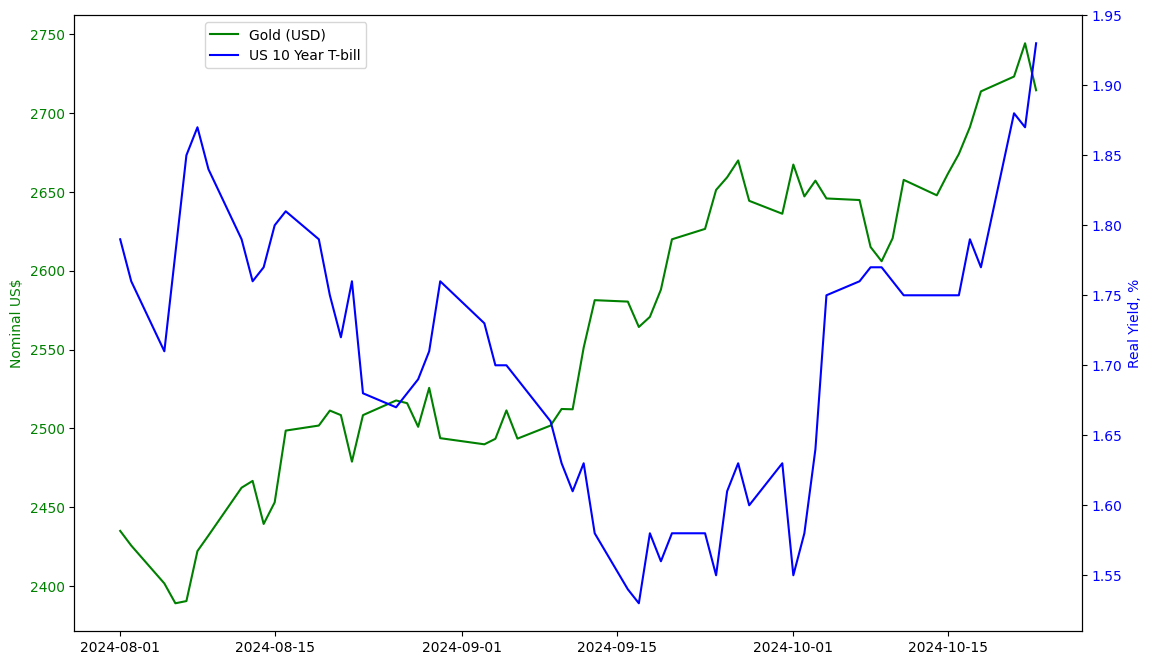

In [536]:
fig, ax1 = plt.subplots()
plt.rcParams["figure.figsize"] = (13,8)

ax1.plot(df.index, df.gold_nomusd, 'g-', label='Gold (USD)')
ax1.set_ylabel('Nominal US$', color='g')
ax1.tick_params(axis='y', labelcolor='g')

ax2 = ax1.twinx()

ax2.plot(df.index, df.DFII10, 'b-', label='US 10 Year T-bill')
ax2.set_ylabel('Real Yield, %', color='b')    
ax2.tick_params(axis='y', labelcolor='b')

fig.legend(loc="upper left", bbox_to_anchor=(0.22,0.88))

# Show the plot

plt.show()